<a href="https://colab.research.google.com/github/Bovi-analytics/hut-et-al-2021/blob/master/EatingTime_24h_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical notebook for eating time

## Importing of google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## R loading

In [ ]:
%reload_ext rpy2.ipython

In [ ]:
%%R
lib_loc <- "/content/drive/Shareddrives/Bovi-Analytics/R-lib/"

In [ ]:
%%R
package_list <- c("ggplot2",
                  "readr",
                  "plyr",
                  "dplyr",
                  "tidyr",                
                  "lme4",
                  "lmerTest",
                  "multcompView",
                  "mvtnorm",
                  "TH.data",
                  "multcomp",
                  "emmeans",
                  "lsmeans",
                  "carData",
                  "car"
                  )

for (pkg in package_list) {
  if (pkg %in% rownames(.packages()) == FALSE)
  {library(pkg, lib.loc = lib_loc, character.only = TRUE)}

}

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘Matrix’


R[write to console]: The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: Loading required package: survival

R[write to console]: Loading required package: MASS

R[write to console]: 
Attaching

In [ ]:
%%R
options(warn=-1)

## Data loading into dataframe

In [ ]:
%%R
AnalysisData <- 
  readr::read_csv("/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/ObservationType=EatingTimeMinutesPer2Hours/part-00000-tid-183333261268000902-29b42dfd-564e-4e7d-8ea7-05b4fb30d5d6-1694-5.c000.csv", 
    col_types = readr::cols(HerdIdentifier = readr::col_character(), 
        TransitionLactationNumber = readr::col_integer(), 
        TransitionParity = readr::col_character(), 
        TransitionMonthsInMilk = readr::col_integer(), 
        TransitionCalvingDate = readr::col_character(), 
        Hour = readr::col_integer(), 
        Observations = readr::col_integer())) %>% 
  dplyr::filter(dplyr::between(TransitionMonthsInMilk, 1, 10)) %>%
   dplyr::mutate(
    AnimalIdentifier = factor(AnimalIdentifier),
    HerdIdentifier = factor(HerdIdentifier),
    Parity = factor(TransitionParity),
    MonthsInMilk = factor(TransitionMonthsInMilk),
    CalvingSeason = factor(TransitionSeason),
    Hour = factor(Hour),
    SensorValue = ObservationValue,
    MilkingType = factor(case_when(
    HerdIdentifier %in% c("544", "2514", "3314")~"AMS",
    TRUE~"CMS"
  ))
  ) %>%
  dplyr::select(AnimalIdentifier, HerdIdentifier, Parity, MonthsInMilk, CalvingSeason, Hour, SensorValue, MilkingType) %>%
  tidyr::drop_na()

|===================================================================| 100% 64 MB


In [ ]:
%%R
head(AnalysisData)

# A tibble: 6 x 8
  AnimalIdentifier HerdIdentifier Parity MonthsInMilk CalvingSeason Hour 
  <fct>            <fct>          <fct>  <fct>        <fct>         <fct>
1 55               2297           1      4            Winter        2    
2 140              2746           3+     5            Winter        20   
3 140              2746           3+     6            Winter        6    
4 64               3314           2      1            Winter        18   
5 64               3314           2      5            Winter        0    
6 64               3314           2      5            Winter        14   
# … with 2 more variables: SensorValue <dbl>, MilkingType <fct>


In [ ]:
%%R
str(AnalysisData)

tibble[,8] [417,593 × 8] (S3: tbl_df/tbl/data.frame)
 $ AnimalIdentifier: Factor w/ 1095 levels "1","2","3","4",..: 55 140 140 64 64 64 64 666 96 267 ...
 $ HerdIdentifier  : Factor w/ 8 levels "2011","2297",..: 2 4 4 6 6 6 6 2 7 3 ...
 $ Parity          : Factor w/ 3 levels "1","2","3+": 1 3 3 2 2 2 2 1 2 3 ...
 $ MonthsInMilk    : Factor w/ 10 levels "1","2","3","4",..: 4 5 6 1 5 5 8 10 5 5 ...
 $ CalvingSeason   : Factor w/ 4 levels "Autumn","Spring",..: 4 4 4 4 4 4 4 3 1 3 ...
 $ Hour            : Factor w/ 12 levels "0","2","4","6",..: 2 11 4 10 1 8 3 4 4 4 ...
 $ SensorValue     : num [1:417593] 19.7 18.7 33 41.9 16.5 ...
 $ MilkingType     : Factor w/ 2 levels "AMS","CMS": 2 2 2 1 1 1 1 2 1 1 ...


## Descriptive statistics

In [ ]:
%%R
AnalysisData %>% group_by("Parity") %>% n_distinct()

[1] 417496


In [ ]:
%%R
AnalysisData %>%
  group_by(Parity) %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 3 x 2
  Parity Unique_Elements
  <fct>            <int>
1 1                  696
2 2                  686
3 3+                 724


In [ ]:
%%R
AnalysisData %>%
  summarise(Unique_Elements = n_distinct(AnimalIdentifier))

# A tibble: 1 x 1
  Unique_Elements
            <int>
1            1067


# Model building

First we determine the null model

## Null model

In [ ]:
%%R
Model.0 <- lme4::lmer(
                  SensorValue ~ 1 + (1| HerdIdentifier:AnimalIdentifier), 
                  data = AnalysisData
                  )


## Univariable models

In [ ]:
%%R
Model1.0 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model.0,Model1.0,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.0: SensorValue ~ MonthsInMilk + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3466198 3466231 -1733096  3466192                         
Model1.0   12 3464816 3464948 -1732396  3464792 1399.6  9  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.1 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.1,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.1: SensorValue ~ Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3466198 3466231 -1733096  3466192                         
Model1.1    5 3462233 3462288 -1731112  3462223 3968.9  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.2 <- lme4::lmer(
                  SensorValue ~ 
                  HerdIdentifier + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.2,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.2: SensorValue ~ HerdIdentifier + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq Df Pr(>Chisq)    
Model.0     3 3466198 3466231 -1733096  3466192                        
Model1.2   10 3465888 3465998 -1732934  3465868 323.7  7  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.3 <- lme4::lmer(
                  SensorValue ~ 
                  CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.3,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.3: SensorValue ~ CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3466198 3466231 -1733096  3466192                         
Model1.3    6 3466073 3466139 -1733030  3466061 131.04  3  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.4,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.4: SensorValue ~ Hour + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3466198 3466231 -1733096  3466192                         
Model1.4   14 3266519 3266672 -1633246  3266491 199701 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model1.5 <- lme4::lmer(
                  SensorValue ~ 
                  MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )
anova(Model.0,Model1.5,test="Chisq")

R[write to console]: refitting model(s) with ML (instead of REML)



Data: AnalysisData
Models:
Model.0: SensorValue ~ 1 + (1 | HerdIdentifier:AnimalIdentifier)
Model1.5: SensorValue ~ MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model.0     3 3466198 3466231 -1733096  3466192                         
Model1.5    4 3466123 3466166 -1733057  3466115 77.417  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multivariable models

In [ ]:
%%R
Model2.0 <- lme4::lmer(
                  SensorValue ~ 
                  Parity + MonthsInMilk + CalvingSeason + Hour + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
                  )

In [ ]:
%%R
drop1(Model2.0,test="Chisq")

Single term deletions

Model:
SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
    MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
              npar     AIC    LRT   Pr(Chi)    
<none>             3258297                     
Parity           2 3264040   5747 < 2.2e-16 ***
MonthsInMilk     9 3260010   1730 < 2.2e-16 ***
CalvingSeason    3 3258411    120 < 2.2e-16 ***
Hour            11 3461025 202750 < 2.2e-16 ***
MilkingType      1 3258368     73 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Introduction of interactions

### Interactions with MonthsInMilk

In [ ]:
%%R
Model2.1 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + Hour + HerdIdentifier + CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.1,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.1: SensorValue ~ MonthsInMilk * Parity + Hour + HerdIdentifier + 
Model2.1:     CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3258297 3258615 -1629120  3258239                         
Model2.1   53 3257290 3257870 -1628592  3257184 1055.2 24  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.2 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*MilkingType + Parity + Hour + CalvingSeason +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.2,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.2: SensorValue ~ MonthsInMilk * MilkingType + Parity + Hour + CalvingSeason + 
Model2.2:     (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq Df Pr(>Chisq)    
Model2.0   29 3258297 3258615 -1629120  3258239                        
Model2.2   38 3258206 3258622 -1629065  3258130 109.7  9  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.3 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*CalvingSeason + Parity + Hour + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.3,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.3: SensorValue ~ MonthsInMilk * CalvingSeason + Parity + Hour + 
Model2.3:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3258297 3258615 -1629120  3258239                         
Model2.3   56 3257547 3258160 -1628718  3257435 804.44 27  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Interactions with Hour

In [ ]:
%%R
Model2.4 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*Parity + MonthsInMilk + CalvingSeason + MilkingType + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.4,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.4: SensorValue ~ Hour * Parity + MonthsInMilk + CalvingSeason + 
Model2.4:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3258297 3258615 -1629120  3258239                         
Model2.4   51 3256105 3256663 -1628001  3256003 2236.7 22  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.5 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*MilkingType + MonthsInMilk + CalvingSeason + Parity + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.5,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.5: SensorValue ~ Hour * MilkingType + MonthsInMilk + CalvingSeason + 
Model2.5:     Parity + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3258297 3258615 -1629120  3258239                         
Model2.5   40 3249524 3249962 -1624722  3249444 8795.5 11  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
Model2.6 <- lme4::lmer(
                  SensorValue ~ 
                  Hour*CalvingSeason + MonthsInMilk +  + Parity + MilkingType +
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.6,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.6: SensorValue ~ Hour * CalvingSeason + MonthsInMilk + +Parity + 
Model2.6:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance  Chisq Df Pr(>Chisq)    
Model2.0   29 3258297 3258615 -1629120  3258239                         
Model2.6   62 3257456 3258135 -1628666  3257332 907.34 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## Multiple interactions

In [ ]:
%%R
Model2.7 <- lme4::lmer(
                  SensorValue ~ 
                  MonthsInMilk*Parity + 
                  MonthsInMilk*MilkingType + 
                  MonthsInMilk*CalvingSeason + 
                  Hour*Parity + 
                  Hour*MilkingType + 
                  Hour*CalvingSeason + 
                  (1| HerdIdentifier:AnimalIdentifier),
                  REML = FALSE,
                  data = AnalysisData
)
anova(Model2.0,Model2.7,test="Chisq")

Data: AnalysisData
Models:
Model2.0: SensorValue ~ Parity + MonthsInMilk + CalvingSeason + Hour + 
Model2.0:     MilkingType + (1 | HerdIdentifier:AnimalIdentifier)
Model2.7: SensorValue ~ MonthsInMilk * Parity + MonthsInMilk * MilkingType + 
Model2.7:     MonthsInMilk * CalvingSeason + Hour * Parity + Hour * MilkingType + 
Model2.7:     Hour * CalvingSeason + (1 | HerdIdentifier:AnimalIdentifier)
         npar     AIC     BIC   logLik deviance Chisq  Df Pr(>Chisq)    
Model2.0   29 3258297 3258615 -1629120  3258239                         
Model2.7  149 3244897 3246528 -1622300  3244599 13640 120  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Final model analysis of variance

In [ ]:
%%R
finalModel <- Model2.7

In [ ]:
%%R
Anova(finalModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: SensorValue
                                Chisq Df Pr(>Chisq)    
MonthsInMilk                 1791.612  9  < 2.2e-16 ***
Parity                       6003.029  2  < 2.2e-16 ***
MilkingType                    75.513  1  < 2.2e-16 ***
CalvingSeason                 119.544  3  < 2.2e-16 ***
Hour                       269999.023 11  < 2.2e-16 ***
MonthsInMilk:Parity           813.530 18  < 2.2e-16 ***
MonthsInMilk:MilkingType      131.116  9  < 2.2e-16 ***
MonthsInMilk:CalvingSeason    893.498 27  < 2.2e-16 ***
Parity:Hour                  2231.254 22  < 2.2e-16 ***
MilkingType:Hour             8897.833 11  < 2.2e-16 ***
CalvingSeason:Hour            828.671 33  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [ ]:
%%R
save(finalModel, file="/content/drive/Shareddrives/Bovi-Analytics/Projects/SenseOfSensors/CsvData/SensorAggRepartitioned08032021/finalmodel2hourseatingtime.rdata")

# Final model figures and LSM (95% CI)

## Main effects

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ MonthsInMilk), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 MonthsInMilk lsmean    SE  df asymp.LCL asymp.UCL .group 
 1              26.3 0.136 Inf      25.9      26.7  a     
 2              27.3 0.136 Inf      26.9      27.7   b    
 3              27.9 0.136 Inf      27.6      28.3    c   
 4              28.3 0.136 Inf      27.9      28.6     d  
 10             28.3 0.137 Inf      28.0      28.7     d  
 9              28.7 0.137 Inf      28.3      29.1      e 
 5              28.8 0.136 Inf      28.4      29.2      ef
 8              28.8 0.136 Inf      28.4      29.2      ef
 7              29.1 0.136 Inf      28.7      29.4       f
 6              29.1 0.136 Inf      28.7      29.5       f

Results are averaged over the levels of: Parity, MilkingType, CalvingSeason, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 10 estimates 
P value adjustment: tukey method for comparing a family of 10 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Parity), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Parity lsmean    SE  df asymp.LCL asymp.UCL .group
 3+       25.6 0.125 Inf      25.3      25.9  a    
 2        29.1 0.126 Inf      28.8      29.4   b   
 1        30.1 0.127 Inf      29.7      30.4    c  

Results are averaged over the levels of: MonthsInMilk, MilkingType, CalvingSeason, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 3 estimates 
P value adjustment: tukey method for comparing a family of 3 estimates 
significance level used: alpha = 0.05 


In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ Hour), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 4      9.93 0.139 Inf      9.54      10.3  a          
 2     16.96 0.139 Inf     16.56      17.4   b         
 6     17.35 0.139 Inf     16.95      17.7    c        
 0     21.14 0.139 Inf     20.74      21.5     d       
 22    24.44 0.139 Inf     24.04      24.8      e      
 8     32.33 0.139 Inf     31.93      32.7       f     
 12    33.80 0.139 Inf     33.40      34.2        g    
 16    34.71 0.139 Inf     34.31      35.1         h   
 14    34.81 0.139 Inf     34.41      35.2         h   
 20    36.53 0.139 Inf     36.14      36.9          i  
 18    38.04 0.139 Inf     37.64      38.4           j 
 10    39.02 0.139 Inf     38.63      39.4            k

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType, CalvingSeason 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 12 estimates 
P value adjustment: tukey method for comparing a family of

In [ ]:
%%R
multcomp::cld(lsmeans::lsmeans(finalModel, ~ CalvingSeason), alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



 CalvingSeason lsmean    SE  df asymp.LCL asymp.UCL .group
 Summer          27.8 0.130 Inf      27.5      28.1  a    
 Autumn          28.1 0.131 Inf      27.8      28.4   b   
 Spring          28.3 0.133 Inf      28.0      28.6   b   
 Winter          28.8 0.134 Inf      28.5      29.1    c  

Results are averaged over the levels of: MonthsInMilk, Parity, MilkingType, Hour 
Degrees-of-freedom method: asymptotic 
Confidence level used: 0.95 
Conf-level adjustment: sidak method for 4 estimates 
P value adjustment: tukey method for comparing a family of 4 estimates 
significance level used: alpha = 0.05 


## Interactions


### Hour by parity

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|Parity, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



Parity = 1:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group     
 4     10.23 0.176 Inf      9.73     10.73  a         
 2     17.40 0.176 Inf     16.90     17.91   b        
 6     19.70 0.176 Inf     19.20     20.20    c       
 0     22.39 0.176 Inf     21.89     22.89     d      
 22    27.47 0.176 Inf     26.97     27.98      e     
 8     34.31 0.176 Inf     33.80     34.81       f    
 12    35.42 0.176 Inf     34.92     35.92        g   
 16    36.51 0.176 Inf     36.00     37.01         h  
 14    36.80 0.176 Inf     36.30     37.30         h  
 20    39.65 0.176 Inf     39.15     40.15          i 
 18    39.90 0.176 Inf     39.39     40.40          i 
 10    40.83 0.176 Inf     40.33     41.33           j

Parity = 2:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group     
 4     10.22 0.176 Inf      9.72     10.73  a         
 6     17.60 0.176 Inf     17.09     18.10   b        
 2     17.67 0.176 Inf     17.17     18.18   b        
 0     21.49 0.176 Inf     20.99     21.

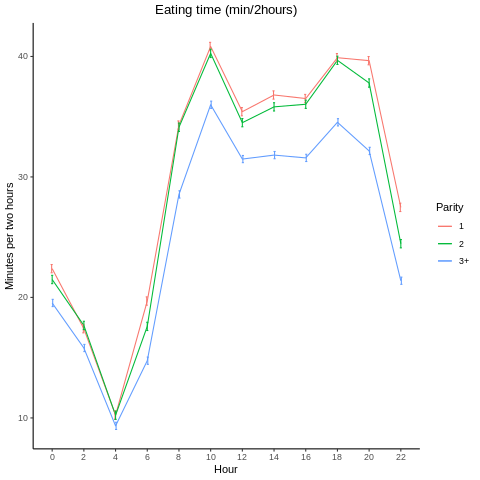

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(Parity), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=Parity, 
    color=Parity)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Eating time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### Hour by milking type

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|MilkingType, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



MilkingType = AMS:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group    
 4     10.15 0.225 Inf      9.51      10.8  a        
 6     17.14 0.225 Inf     16.50      17.8   b       
 2     17.56 0.225 Inf     16.92      18.2   b       
 0     20.07 0.225 Inf     19.42      20.7    c      
 22    23.41 0.225 Inf     22.76      24.1     d     
 12    28.78 0.225 Inf     28.14      29.4      e    
 8     30.01 0.225 Inf     29.36      30.7       f   
 14    30.77 0.225 Inf     30.13      31.4        g  
 16    34.43 0.225 Inf     33.79      35.1         h 
 18    37.77 0.225 Inf     37.12      38.4          i
 10    38.15 0.225 Inf     37.50      38.8          i
 20    38.22 0.225 Inf     37.58      38.9          i

MilkingType = CMS:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group    
 4      9.71 0.160 Inf      9.25      10.2  a        
 2     16.36 0.160 Inf     15.90      16.8   b       
 6     17.56 0.160 Inf     17.10      18.0    c      
 0     22.21 0.160 Inf     21.75      22.7 

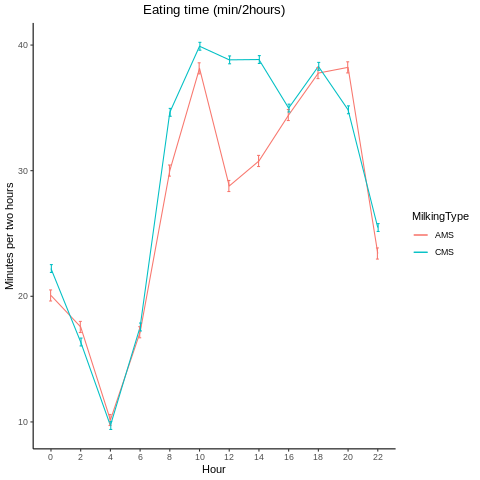

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(MilkingType), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=MilkingType, 
    color=MilkingType)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Eating time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))

### Hour by calving season

In [ ]:
%%R
LSMs<-lsmeans::lsmeans(finalModel, pairwise ~ Hour|CalvingSeason, type = "response", glhargs=list())
multcomp::cld(LSMs[[1]], alpha=0.05, Letters=letters, adjust="tukey")

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 417593' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 417593' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 417593)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



CalvingSeason = Autumn:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 4     10.24 0.178 Inf      9.73     10.75  a          
 6     16.30 0.178 Inf     15.79     16.81   b         
 2     17.08 0.178 Inf     16.57     17.59    c        
 0     21.16 0.178 Inf     20.65     21.66     d       
 22    24.96 0.178 Inf     24.45     25.47      e      
 8     31.64 0.178 Inf     31.13     32.14       f     
 12    34.03 0.178 Inf     33.52     34.54        g    
 16    34.12 0.178 Inf     33.62     34.63        gh   
 14    34.62 0.178 Inf     34.12     35.13         h   
 20    36.62 0.178 Inf     36.12     37.13          i  
 18    37.22 0.178 Inf     36.71     37.73           j 
 10    39.38 0.178 Inf     38.88     39.89            k

CalvingSeason = Spring:
 Hour lsmean    SE  df asymp.LCL asymp.UCL .group      
 4      9.62 0.186 Inf      9.09     10.15  a          
 2     16.86 0.186 Inf     16.33     17.39   b         
 6     18.17 0.186 Inf     17.64     18.71    c        

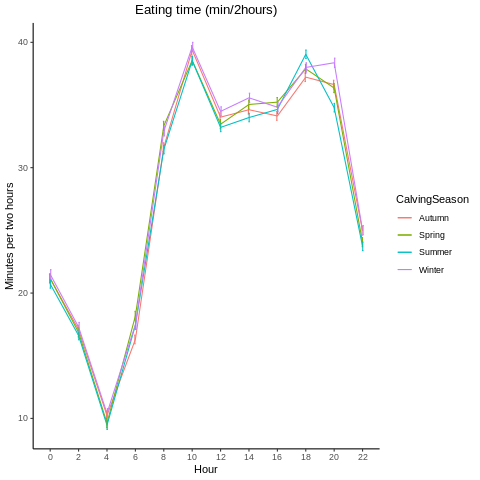

In [ ]:
%%R
dfPValues <- summary(LSMs)[[2]]
dfLMSs <- summary(LSMs)[[1]]
dfLMSs %>% 
  mutate(label = if_else(Hour == max(as.numeric(Hour)), as.character(CalvingSeason), NA_character_)) %>%
  ggplot(
  aes(
    x=Hour,
    y=lsmean,
    group=CalvingSeason, 
    color=CalvingSeason)
    ) +
  geom_line() +  
  geom_errorbar(
    aes(ymin=asymp.LCL, 
        ymax=asymp.UCL), 
    width=.2,
    position=position_dodge(0.05)) +
  labs(
    title = "Eating time (min/2hours)", 
    y="Minutes per two hours" , 
    x = "Hour") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"))